In [1]:
import numpy as np 
from astropy.coordinates import SkyCoord
import astropy.units as u 
from transforms import pm_to_dxyz


def coeval(star, center, times, rv):
    # get the center's position at each time t
    cen_xyz = center.cartesian.xyz #shape(3,)
    cen_d_xyz = center.velocity.d_xyz #shape(3,)

    #relying on astropy to do unit conversion from km/s to pc/year

    #center displacements in {x,y,z} at each time step; shape(time,{x,y,z})
    cen_delta_t = np.outer(times, cen_d_xyz) #shape(times,{x,y,z})

    #ceneter position at time t: shape(time, {x,y,z})
    cen_pos_t = cen_xyz[np.newaxis,:]+cen_delta_t

    #work on the star
    star_xyz = star.cartesian.xyz

    #need 2d array (rv x {dx,dy,dz}) for each rv (need to transpose result of pm_to_dxyz)
    star_rv_d_xyz = pm_to_dxyz(star.ra.value, star.dec.value, star.distance.value,
                star.pm_ra_cosdec.value, star.pm_dec.value, rv.value).T*u.km/u.second
    
    #3d array (rv x time x {x,y,z}) of star's displacements
    star_delta_rv_t2 = np.outer(times, star_rv_d_xyz)
    star_delta_rv_t1 = star_delta_rv_t2.reshape( len(times), len(rv), 3)
    star_delta_rv_t = star_delta_rv_t1.transpose(1,0,2)

    #3d postion of star for each rv, time pair: shape(rv, times, {x,y,z})
    star_pos_rv_t = star_xyz[np.newaxis, np.newaxis, :] + star_delta_rv_t

    #get star position wrt center at time t
    star_off_rv_t = star_pos_rv_t - cen_pos_t[np.newaxis,:]

    star_cen_dist_rv_t2 = (star_off_rv_t**2).sum(axis=2)

    assert star_cen_dist_rv_t2.shape == (len(rv), len(times))

    return np.sqrt(star_cen_dist_rv_t2)

if __name__ == "__main__":

    center = SkyCoord(ra=56.44*u.degree, dec= 23.86*u.degree, distance=135.79576317*u.pc,
            pm_ra_cosdec=19.997*u.mas/u.year, pm_dec=-45.548*u.mas/u.year,
            radial_velocity= 5.65*u.km/u.second)
    
    print(center)

    star = SkyCoord(ra=45.76103592*u.degree, dec=1.66188041*u.degree, distance=147.80520028*u.pc,
            pm_ra_cosdec = -30.50401334*u.mas/u.year, pm_dec = 33.25870675*u.mas/u.year)
    print(star)

    print(f'Current separation: {star.separation_3d(center)}')

    rv = [-5, 0 ,2.0, 4]*u.km/u.second
    times = [-24e6, -20e6, -10e6, -1e6, 0]*u.year

    test_coeval = coeval(star, center, times, rv)

    print(test_coeval)


<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (56.44, 23.86, 135.79576317)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (19.997, -45.548, 5.65)>
<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (45.76103592, 1.66188041, 147.80520028)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-30.50401334, 33.25870675)>
Current separation: 61.27829293042041 pc
[[1596.6482661  1336.27189767  685.87813582  110.63005432   61.27829293]
 [1564.02174742 1308.88674427  671.62532758  108.73158399   61.27829293]
 [1553.49600072 1300.02559367  666.93748003  108.03064331   61.27829293]
 [1544.45955416 1292.39915956  662.84792828  107.36409992   61.27829293]] pc


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np

In [3]:
def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

In [4]:
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 40)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

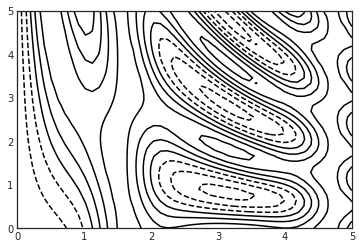

In [5]:
plt.contour(X, Y, Z, colors='black');

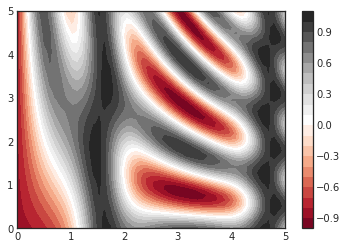

In [6]:
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar();

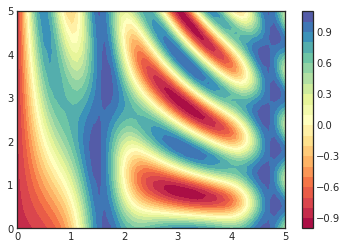

In [9]:
plt.contourf(X, Y, Z, 20, cmap='Spectral')
plt.colorbar();

In [10]:
times = np.linspace(-120e6, -50e6, 1000)*u.year
rv = np.linspace(-100, 100, 1000)*u.km/u.second

In [11]:
test_coeval = coeval(star, center, times, rv)

In [12]:
test_coeval.shape

(1000, 1000)

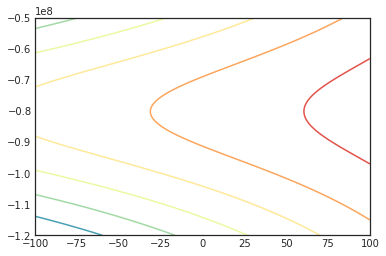

In [13]:
plt.contour(rv, times, test_coeval, cmap='Spectral')

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

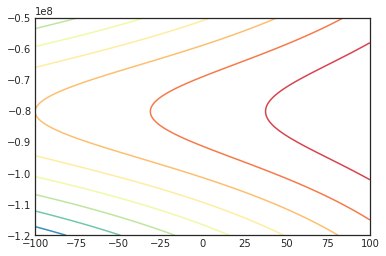

In [14]:
plt.contour(rv, times, test_coeval,10, cmap='Spectral')
plt.colorbar

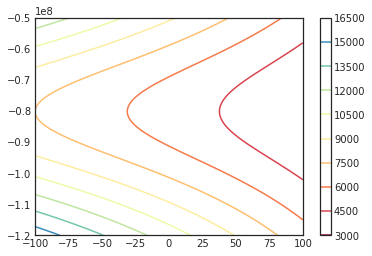

In [15]:
plt.contour(rv, times, test_coeval,10, cmap='Spectral')
plt.colorbar()

In [16]:
RV, TIMES = np.meshgrid(rv, times)

In [17]:
plt.contour(RV, TIMES, test_coeval.flatten(),10, cmap='spectral')
plt.colorbar()

TypeError: Input z must be a 2D array.

In [18]:
Z.shape

(40, 50)

In [19]:
X.shape

(40, 50)

In [20]:
plt.contour(RV, TIMES, test_coeval,10, cmap='spectral')
plt.colorbar()

ValueError: Colormap spectral is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

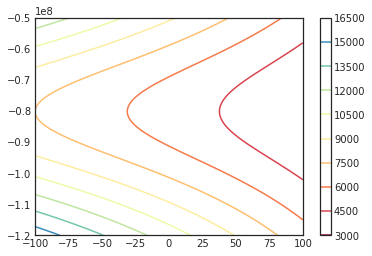

In [21]:
plt.contour(RV, TIMES, test_coeval,10, cmap='Spectral')
plt.colorbar()

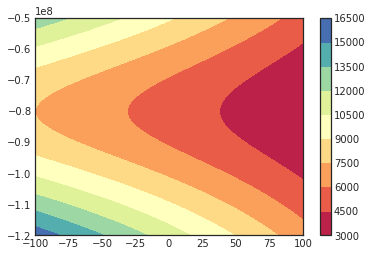

In [22]:
plt.contourf(RV, TIMES, test_coeval,10, cmap='Spectral')
plt.colorbar()

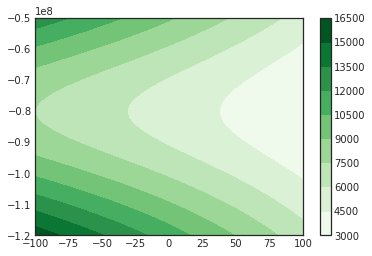

In [23]:
plt.contourf(RV, TIMES, test_coeval,10, cmap='Greens')
plt.colorbar()

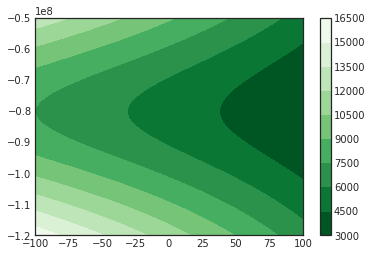

In [24]:
plt.contourf(RV, TIMES, test_coeval,10, cmap='Greens_r')
plt.colorbar()

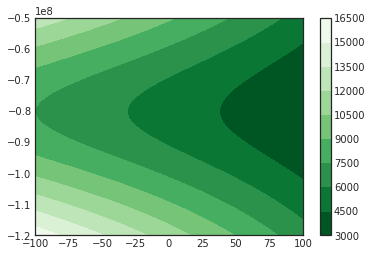

In [25]:
plt.contourf(rv, times, test_coeval,10, cmap='Greens_r')
plt.colorbar()

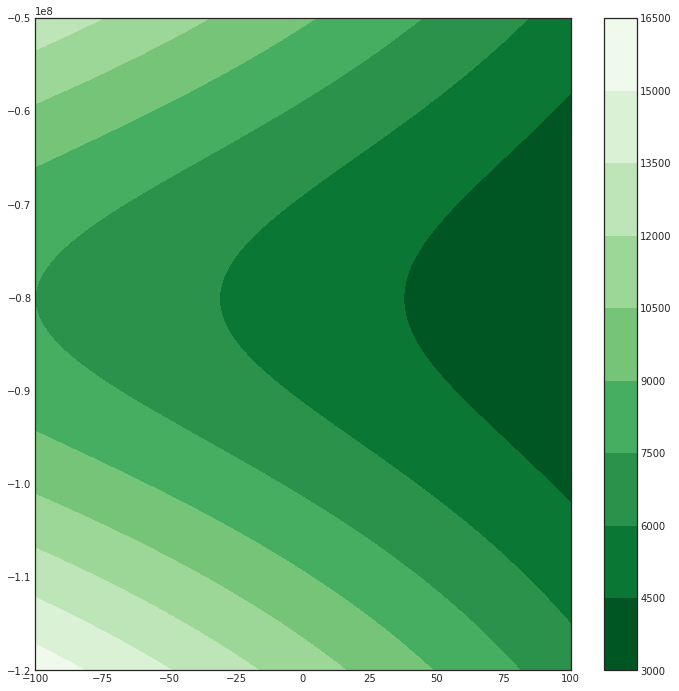

In [26]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval, 10, cmap='Greens_r')
fig.colorbar(pcm)

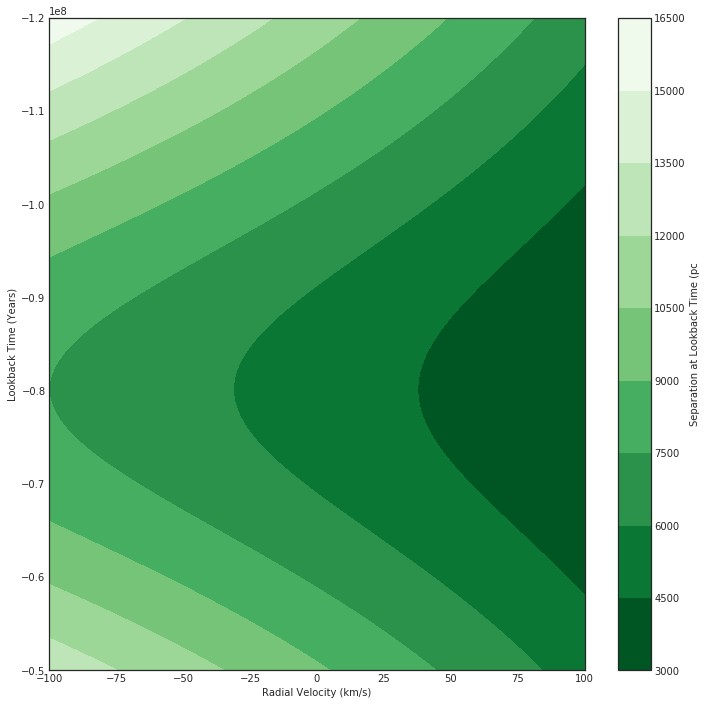

In [27]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval, 10, cmap='Greens_r')
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
fig.colorbar(pcm, label='Separation at Lookback Time (pc')

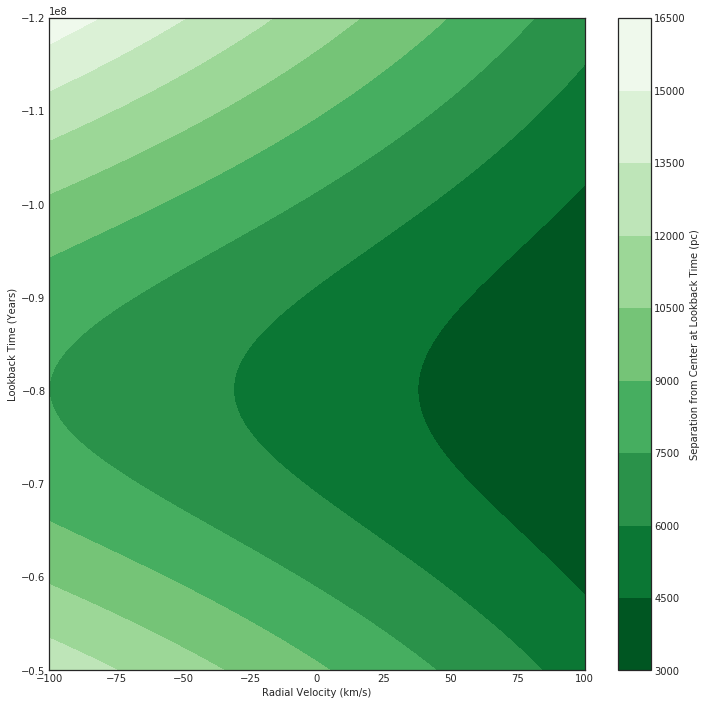

In [28]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval, 10, cmap='Greens_r')
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid()
fig.colorbar(pcm, label='Separation from Center at Lookback Time (pc)')

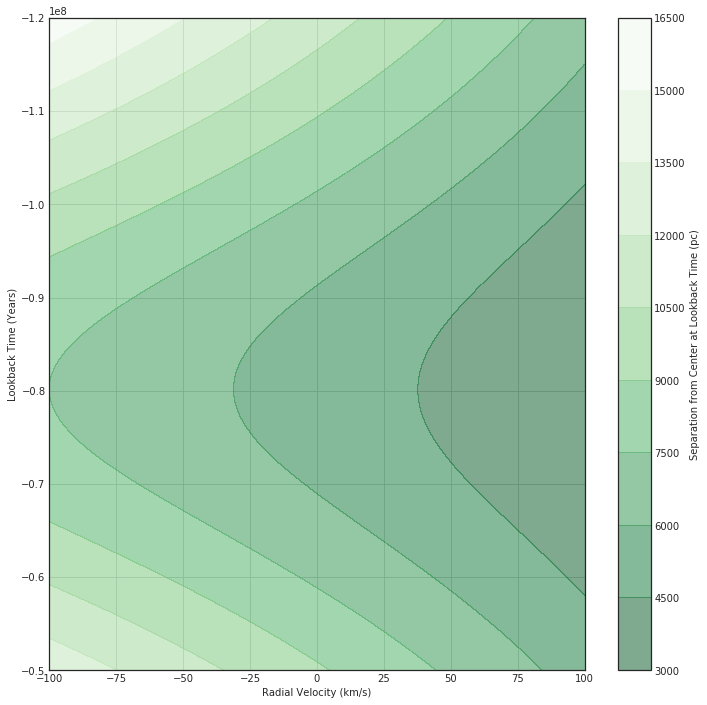

In [29]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval, 10, cmap='Greens_r',alpha=0.5)
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid()
fig.colorbar(pcm, label='Separation from Center at Lookback Time (pc)')

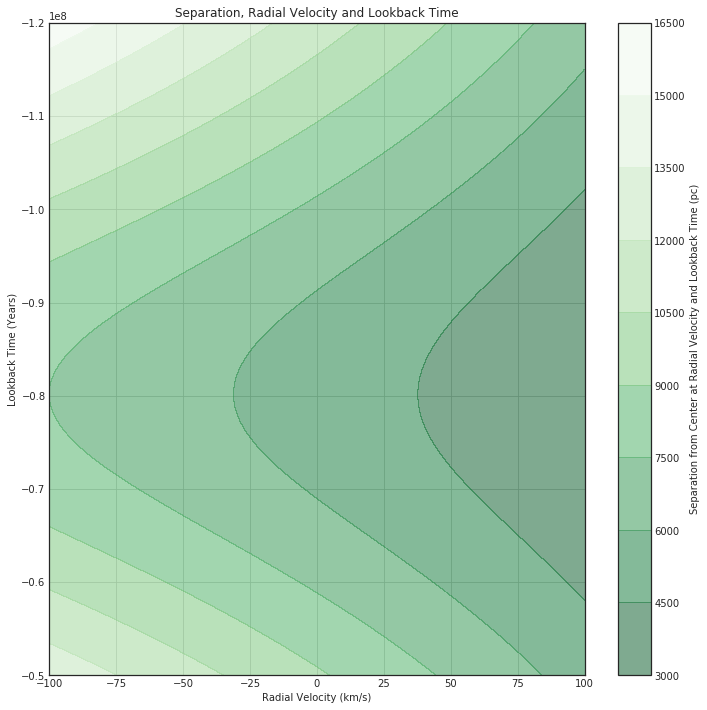

In [30]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval, 10, cmap='Greens_r',alpha=0.5)
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid()
ax.set_title('Separation, Radial Velocity and Lookback Time')
fig.colorbar(pcm, label='Separation from Center at Radial Velocity and Lookback Time (pc)')

In [31]:
cl='alphaPer'
source_id = 349912948408076544
search_results[cl]

NameError: name 'search_results' is not defined

In [32]:
times = np.linspace(-120e6, -50e6, 15)*u.year
rv = np.linspace(-100, 100, 10)*u.km/u.second

In [33]:
test_coeval = coeval(star, center, times, rv)

In [34]:
test_coeval.shape

(10, 15)

In [35]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval, 10, cmap='Greens_r',alpha=0.5)
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid()
ax.set_title('Separation, Radial Velocity and Lookback Time')
fig.colorbar(pcm, label='Separation from Center at Radial Velocity and Lookback Time (pc)')

TypeError: Length of x must be number of columns in z.

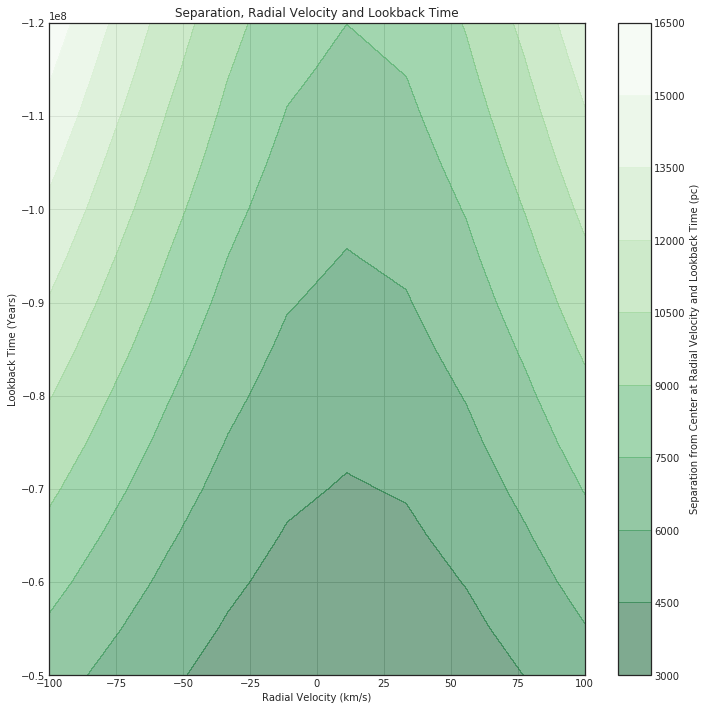

In [36]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval.T, 10, cmap='Greens_r',alpha=0.5)
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid()
ax.set_title('Separation, Radial Velocity and Lookback Time')
fig.colorbar(pcm, label='Separation from Center at Radial Velocity and Lookback Time (pc)')

In [37]:
test_coeval[:,-1]

<Quantity [6626.64241748, 5651.81986489, 4749.3488152 , 3968.89517108,
           3395.66074821, 3145.06967841, 3291.65353196, 3789.60037394,
           4524.34827806, 5400.08814886] pc>

In [38]:
times[-1]

<Quantity -50000000. yr>

In [39]:
test_coeval[:,0]

<Quantity [15856.04432612, 13515.0223502 , 11347.82402692,  9474.49126501,
            8101.50929646,  7508.56275167,  7873.89166016,  9082.58876759,
           10856.53080554, 12965.75092724] pc>

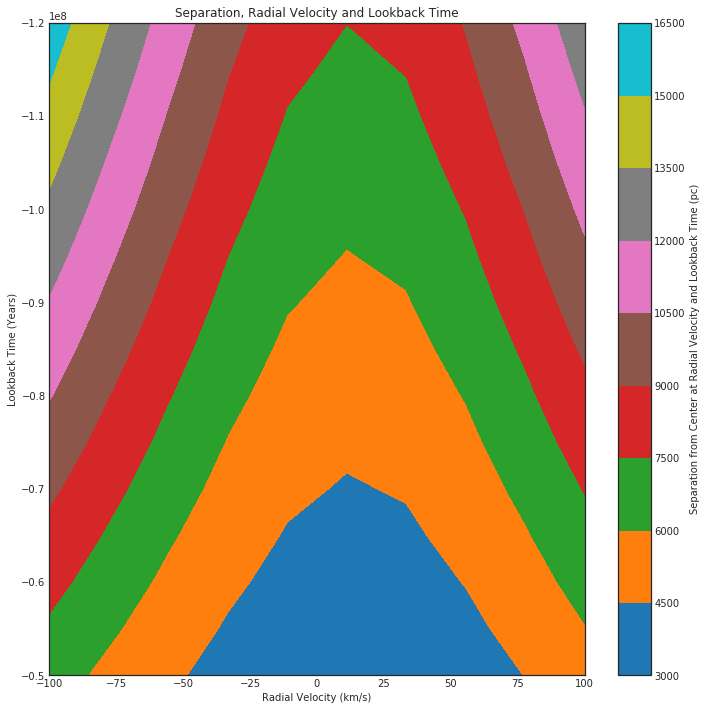

In [40]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval.T, 10, cmap='tab10')
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid()
ax.set_title('Separation, Radial Velocity and Lookback Time')
fig.colorbar(pcm, label='Separation from Center at Radial Velocity and Lookback Time (pc)')

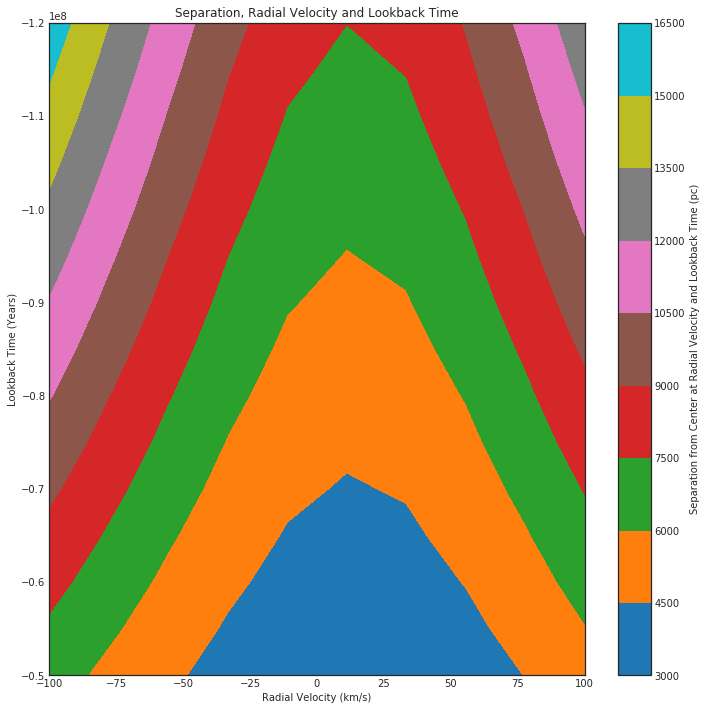

In [41]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval.T, 10, cmap='tab10')
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid(color="white")
ax.set_title('Separation, Radial Velocity and Lookback Time')
fig.colorbar(pcm, label='Separation from Center at Radial Velocity and Lookback Time (pc)')

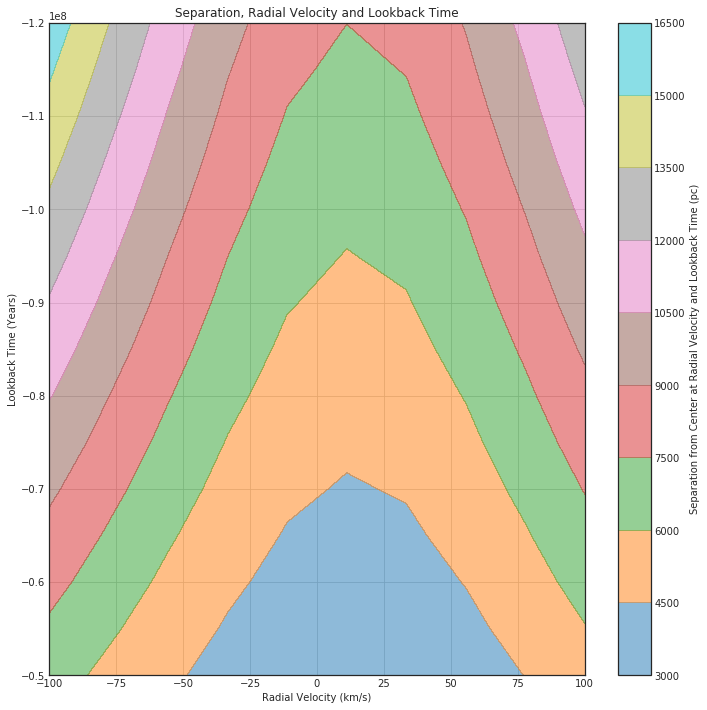

In [42]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
pcm = ax.contourf(rv, times, test_coeval.T, 10, alpha=0.5, cmap='tab10')
ax.set_xlabel('Radial Velocity (km/s)')
ax.set_ylabel('Lookback Time (Years)')
ax.invert_yaxis()
ax.grid()
ax.set_title('Separation, Radial Velocity and Lookback Time')
fig.colorbar(pcm, label='Separation from Center at Radial Velocity and Lookback Time (pc)')

In [43]:
rv

<Quantity [-100.        ,  -77.77777778,  -55.55555556,  -33.33333333,
            -11.11111111,   11.11111111,   33.33333333,   55.55555556,
             77.77777778,  100.        ] km / s>

In [44]:
test_coeval[:,0]

<Quantity [15856.04432612, 13515.0223502 , 11347.82402692,  9474.49126501,
            8101.50929646,  7508.56275167,  7873.89166016,  9082.58876759,
           10856.53080554, 12965.75092724] pc>